# DNN Architecture Early Test

This notebook provides an early prototype for Implementing Deep Neural Network. There are many things that are improved in the final version. Do not rely on this notebook.

## Import Libraries

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [46]:

# https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they
# I wanna be able to stack layers
# idea is if tthis get passed to antoher then it will build the neural net
# build weight matrix
# get frontprop calc to work

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)


def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: np.ones_like(x))  # No activation
}

class LinearLayer():
    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        self.W = (np.random.randn(inFeature, outFeature) * np.sqrt(2 / (inFeature + outFeature))).astype(np.float64)
        self.b = np.zeros((1, outFeature), dtype=np.float64)
        self.trainable = True
        self.activation, self.activation_deriv = activation_map.get(activationFunction, (None, None))
        self.y = self.z = self.X = None

    def Forward(self, X):
        self.X = X
        self.z = X @ self.W + self.b
        self.y = self.activation(self.z)
        return self.y

    def BackwardHidden(self, dEdy, lr=0.01):
        dydx = self.activation_deriv(self.z)
        dEdx = dEdy * dydx
        dEdW = self.X.T @ dEdx
        dEdb = np.sum(dEdx, axis=0, keepdims=True)
        
        if self.trainable:
            self.W -= lr * dEdW
            self.b -= lr * dEdb

        return dEdx @ self.W.T

class Model():
    def __init__(self, layers) -> None:
        self.layers = layers

    def ForwardProp(self, X):
        for layer in self.layers:
            X = layer.Forward(X)
        return X

    def BackwardProp(self, dEdy, learningRate=0.01):
        for layer in reversed(self.layers):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)
        
    def train(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, X_test=None, y_test=None):
        train_loss=[]
        train_metrics=[]
        test_loss=[]
        test_metrics=[]
        for epoch in range(epochs):
            logits = self.ForwardProp(X_train)
            probs = softmax(logits)
            loss = loss_fn(probs, y_train)
            metrics = metrics_fn(probs, y_train)
            train_loss.append(loss)
            train_metrics.append(metrics)
            # Gradient of softmax + categorical crossentropy
            dEdy = (probs - y_train) / y_train.shape[0]
            self.BackwardProp(dEdy, learningRate)

            if X_test and y_test is not None:
                test_logits = self.ForwardProp(X_test)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f},")
            else:
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}")
                
        return {"train_loss": train_loss,
             "train_metrics": train_metrics,
             "test_loss": test_loss,
             "test_metrics": test_metrics}

def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

def accuracy(y_pred, y_true):
    # Get predicted class indicesa
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

def plot_decision_boundary(model, X, y, resolution=0.01):
    # Set min and max values for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a mesh grid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten grid and stack as input
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict using the model
    logits = model.ForwardProp(grid)
    probs = softmax(logits)
    
    predictions = np.argmax(probs, axis=1)
    
    # Reshape to match grid
    zz = predictions.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

In [47]:

a =[0, 0, 1, 1, 0, 0,
   0, 1, 0, 0, 1, 0,
   1, 1, 1, 1, 1, 1,
   1, 0, 0, 0, 0, 1,
   1, 0, 0, 0, 0, 1]
# B
b =[0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 1, 0,
   0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 1, 0,
   0, 1, 1, 1, 1, 0]
# C
c =[0, 1, 1, 1, 1, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 0, 0, 0, 0,
   0, 1, 1, 1, 1, 0]

X_train = np.array([a, b, c])
y_train = np.array([0, 1, 2])  # Labels
y_onehot = toHotEncoding(y_train)

print(X_train.shape, "\n\n", y_train.shape)

(3, 30) 

 (3,)


In [48]:

net = Model([
    LinearLayer(30, 16, 'relu'),
    LinearLayer(16, 3, None)  
])
epochs=10
metrics=net.train(epochs=10, X_train=X_train, y_train=y_onehot, loss_fn=categorical_cross_entropy, metrics_fn=accuracy, X_test=None, y_test=None, learningRate=0.1)
losses=metrics["train_loss"]

preds = softmax(net.ForwardProp(X_train))
print("Predictions:", np.argmax(preds, axis=1))


Epoch: 0, Loss: 0.9497, Acc: 0.6667
Epoch: 1, Loss: 0.8534, Acc: 0.6667
Epoch: 2, Loss: 0.7691, Acc: 0.6667
Epoch: 3, Loss: 0.7092, Acc: 0.6667
Epoch: 4, Loss: 0.6534, Acc: 0.6667
Epoch: 5, Loss: 0.6034, Acc: 1.0000
Epoch: 6, Loss: 0.5601, Acc: 1.0000
Epoch: 7, Loss: 0.5213, Acc: 1.0000
Epoch: 8, Loss: 0.4837, Acc: 1.0000
Epoch: 9, Loss: 0.4484, Acc: 1.0000
Predictions: [0 1 2]


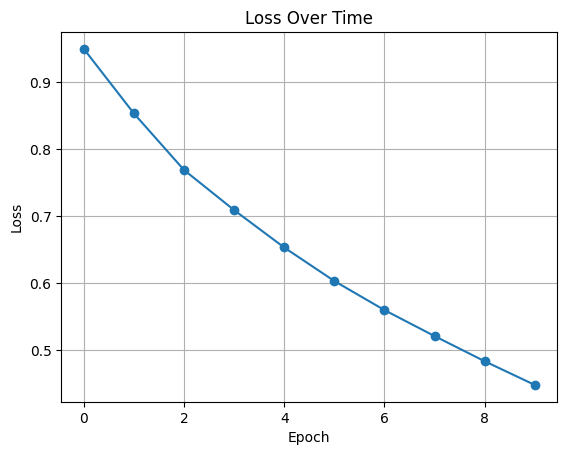

In [49]:
plt.plot(range(epochs), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.grid(True)
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

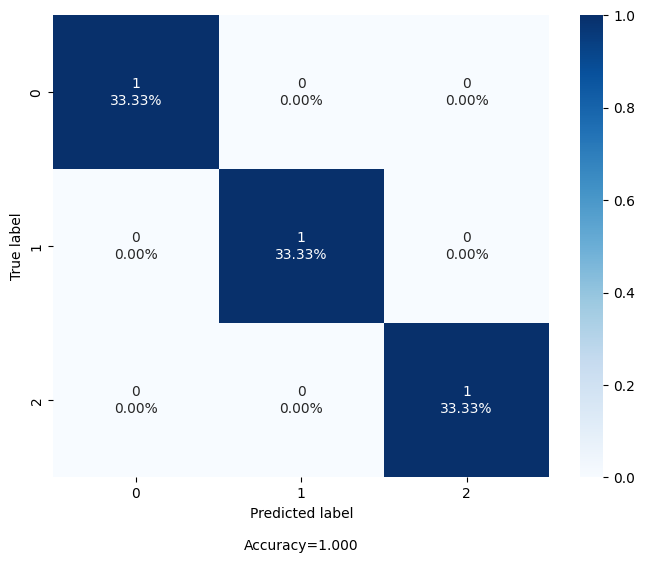

In [51]:
y_true_cls = np.argmax(y_onehot, axis=1)
y_pred_cls = np.argmax(preds, axis=1)
cf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True,sum_stats=True)